In [ ]:
for i in range(10):
    start_time = time.time()
    envs = [lambda: gym.make('CartPole-v0') for x in range(1)]
    venv = ParallelEnvironment(envs)
    agent = PPOAgent(venv, buffer_size=64)
    agent.run(50)
    print("{:.3f}".format(time.time() - start_time))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
import threading
from IPython.display import display
import ipywidgets as widgets
from sidecar import Sidecar

In [ ]:
run_dir = "./runs/agent-27/data/"
line_limit = 10
log_path = run_dir + 'agent.txt'
log_val = []
kill_thread = False
last_frame_count = 0
empty_frame_count = 0

def update_log():
    log_val = ['<li><code style="font-size: 10px;">{}</code></li>'.format(line) for 
               line in list(open(log_path))[-line_limit:]]
    log_widget.value = '<ul style="list-style-type: none; padding: 0;">' + ''.join(log_val) + '</ul>'
    
def on_change(x):
    if (x['name'] == 'value'):
        update_image(x['new'])
        
def kill_thread_click(x):
    global kill_thread
    kill_thread = True
        
def live_update():
    global last_frame_count
    global empty_frame_count
    while True:
        update_count_widget.value = "Last Update: " + time.strftime('%c')
        update_log()
        if last_frame_count == frame_count:
            empty_frame_count += 1
        else:
            last_frame_count = frame_count
            empty_frame_count = 0
        if empty_frame_count > 10 or kill_thread:
            update_count_widget.value = 'Halted: ' + time.strftime('%c')
            break
        time.sleep(1)

play_widget = widgets.Play(
    interval=250,
    value=frame_count,
    min=0,
    max=frame_count,
    step=1,
    description="Press play",
    disabled=False
)
slider_widget = widgets.IntSlider(max=frame_count)
image_widget = widgets.Image(format='png', height=100)
 
slider_widget.observe(on_change)
widgets.jslink((play_widget, 'value'), (slider_widget, 'value'))

log_widget = widgets.HTML()

update_count_widget = widgets.Label()

kill_button_widget = widgets.Button(
    description='Kill Thread'
)
kill_button_widget.on_click(kill_thread_click)

thread = threading.Thread(target=live_update)
thread.start()

training_info = widgets.VBox([image_widget,
                      widgets.HBox([kill_button_widget, play_widget, slider_widget, update_count_widget]),
                      log_widget])

sc = Sidecar(title='Training Info')
with sc:
    display(training_info)

## ZeroMQ

In [ ]:
import zmq

In [ ]:
context = zmq.Context()
with context.socket(zmq.REQ) as socket:
    socket.connect('tcp://127.0.0.1:5555')
    socket.send_string('zeromq')
    msg = socket.recv()
    print(msg)

# Logging

In [1]:
%load_ext autoreload
%autoreload 2
from MarkovDecisionProcess import MarkovDecisionProcess
import numpy as np
import time
import json

In [2]:
mdp = MarkovDecisionProcess(overwrite=True)

In [174]:
mdp.create_log_dir()

In [175]:
logger = mdp.setup_logger("test")

# Testing New Agent

In [1]:
%load_ext autoreload
%autoreload 2
from Agent import Agent
from ParallelEnvironment import ParallelEnvironment
import gym
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.enable_eager_execution(config=config)

## Critic Model

In [2]:
from Agent import CriticModel

In [283]:
input_data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

output_data = np.array([
    [0],
    [1],
    [1],
    [0]
])

critic = CriticModel(len(input_data[0]), len(output_data[0]))

In [287]:
for i in range(100):
    with tf.GradientTape() as tape:
        values = critic(input_data)
        critic_loss = -tf.reduce_sum((output_data - values)**2)

    critic_grad_tensors = tape.gradient(critic_loss, critic.trainable_weights)
    critic_grads = [g.numpy() for g in critic_grad_tensors]
    
    for w, cg in zip(critic.trainable_weights, critic_grads):
        w.assign_add(0.01 * np.array(cg))
        
print(critic_loss)
print(output_data)
print(values)

tf.Tensor(-0.0005360946, shape=(), dtype=float32)
[[0]
 [1]
 [1]
 [0]]
tf.Tensor(
[[0.02063299]
 [0.99328744]
 [0.9926334 ]
 [0.00332403]], shape=(4, 1), dtype=float32)


## Actor Model

In [288]:
from Agent import ActorModel

In [289]:
input_data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

output_data = np.array([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0]
])

In [525]:
actor = ActorModel(3, 3)

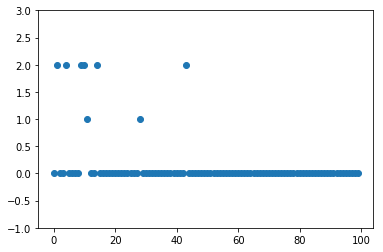

In [549]:
data = []
for i in range(100):
    state = 0 #np.random.choice(3)
    observation = [0,0,0]
    observation[state] = 1
    
    with tf.GradientTape() as tape:
        logits = actor([observation])
        probs = tf.nn.softmax(logits)
        action = np.random.choice(3, p=probs.numpy()[0])
        data.append(action)
        if action == state:
            adv = 1
        else:
            adv = -1
            
        mask = np.zeros(3)
        mask[action] = adv
        actor_loss = tf.log(probs)*mask
        
    actor_grad_tensors = tape.gradient(actor_loss, actor.trainable_weights)
    actor_grads = [g.numpy() for g in actor_grad_tensors]
    
    for w, ag in zip(actor.trainable_weights, actor_grads):
        w.assign_add(0.01*ag)

plt.ylim(-1,3)
plt.plot(data, 'o')

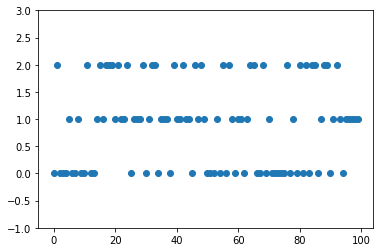

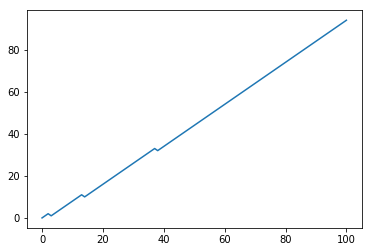

In [563]:
data = []
rews = [0]
for i in range(100):
    state = np.random.choice(3)
    observation = [0,0,0]
    observation[state] = 1
    
    with tf.GradientTape() as tape:
        logits = actor([observation])
        probs = tf.nn.softmax(logits)
        action = np.random.choice(3, p=probs.numpy()[0])
        data.append(action)
        if action == state:
            adv = 1
        else:
            adv = -1
            
        rews.append(adv + rews[-1])
        mask = np.zeros(3)
        mask[action] = adv
        actor_loss = tf.log(probs)*mask
        
    actor_grad_tensors = tape.gradient(actor_loss, actor.trainable_weights)
    actor_grads = [g.numpy() for g in actor_grad_tensors]
    
    #for w, ag in zip(actor.trainable_weights, actor_grads):
    #    w.assign_add(0.01*ag)

plt.ylim(-1,3)
plt.plot(data, 'o')
plt.show()

plt.plot(rews)

In [218]:
env = gym.make('CartPole-v0')
agent = Agent(env)
agent.train(500)

Ep: 99, Rew: 15.0
Ep: 199, Rew: 22.0
Ep: 299, Rew: 35.0
Ep: 399, Rew: 36.0
Ep: 499, Rew: 57.0


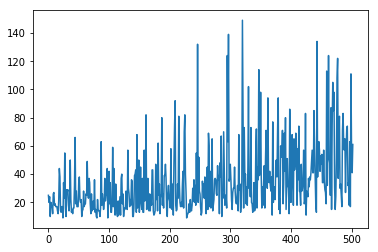

In [52]:
plt.plot(agent.episode_rews)